# Comprehensive Mapping of HIV-1 Escape from a Broadly Neutralizing Antibody
### Adam S. Dingens, Hugh K. Haddox, Julie Overbaugh, and Jesse D. Bloom

### Mutational antigenic profiling of HIV Env from BF520 strain to identify all escape mutants from the PGT151 monoclonal antibody

Experiments performed by Adam Dingens in the [Bloom lab](http://research.fhcrc.org/bloom/en.html) in the autumn of 2016. This analysis has been published in [Cell Host & Microbe](http://dx.doi.org/10.1016/j.chom.2017.05.003) in June 2017.

This notebook processes the Illumina deep sequencing data using the [dms_tools](http://jbloomlab.github.io/dms_tools/) software package, and then analyzes the selection in the context of the antibody.

This is a stripped down analysis that focuses on the key analyses relevant to the final manuscript. This executable analysis is included as a supplemental file to allow others to perform this analysis, as well as to assist others in analyzing their own mutational antigenic profiling data. 

## Import `Python` modules, define widely used functions

In [2]:
import subprocess
import os
import re
import glob
import time
from IPython.display import Image, display
import dms_tools
print("Using dms_tools version {0}".format(dms_tools.__version__))
import dms_tools.file_io


import pandas as pd
import numpy as np
import matplotlib
print "Using matplotlib version %s" % matplotlib.__version__
matplotlib.use("Pdf")
from matplotlib.ticker import MaxNLocator
import pylab as plt
from colour import Color


def ShowPDF(pdfs, width=None, trim=True):
    '''Displays images in *pdfs*, which can be one PDF or list of PDFs. Multiple images displayed side-by-side.'''
    png = '_temp.png'
    if not isinstance(pdfs, list):
        pdfs = [pdfs]
    subprocess.check_call(['convert', '-density', '334'] + {True:['-trim'], False:[]}[trim] + pdfs + ['+append', png])
    time.sleep(0.5)
    display(Image(png, width=width))

Using dms_tools version 1.2.dev1
Using matplotlib version 1.5.3


## Some general information about experimental setup
For this experiment we have three experimental replicates, and are examining selection from a single antibody at a single concentration.

In [3]:
replicates = [1, 2, 3]
antibodies = ['PGT151_1ug']

## Write input files

Below, I write the coding sequence of BF520.W14M.C2 env to a text file. This is available as GenBank accession number [KX168094.1](https://www.ncbi.nlm.nih.gov/nuccore/KX168094.1). 

In [3]:
%%writefile BF520c2-Env.fasta
>BF520.W14.C2
ATGAGAGTGAAGGGGATACAGATGAACTCGCAACACTTATTGAGATGGGGAATTATGATCTTGGGAATGATAATGATCTGTAGTGTTGCAGGAAACTTGTGGGTTACTGTCTACTATGGGGTGCCTGTGTGGAAGGACGCAGAGACCACTCTATTCTGTGCATCAGATGCTAAAGCATATGATGCAGAAGTGCATAATATCTGGGCTACACATGCCTGTGTACCTACAGACCCCAACCCACAAGAAATAAATTTGGAAAATGTGACAGAAGAGTTTAACATGTGGAAAAATAACATGGTAGAACAGATGCATACAGATATAATCAGCCTATGGGACCAAGGCCTAAAGCCATGTGTAAAGTTAACCCCTCTCTGTGTTACTTTAGATTGCCATAATGTCACCTATAATATCACCAGTGACATGAAGGAAGAAATAACAAACTGCTCTTACAATGTGACCACAGTAATAAGGGATAAGAAACAGAAAGTATCCTCACTTTTTTATAAACTTGATGTAGTACAAATTGGAGGTAATAATAGGACTAATAGTCAGTATAGATTAATAAACTGTAACACCTCAGCCATTACACAGGCTTGTCCAAAGGTAACCTTTGAGCCAATTCCCATACATTATTGTGCCCCAGCTGGTTTTGCGATTCTAAAGTGTAAGGATGAGAAGTTCAATGGAACAGGGCTATGTAAAAATGTCAGCACAGTACAATGCACACATGGAATCAAGCCAGTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGGAGAGGTAAGAATTAGATCTGAAAATATCACAAACAATGCCAAAAACATAATAGTACAACTTGCCAGCCCTGTAACAATTAATTGTATCAGACCTAACAACAATACAAGAAAAAGTGTACACCTAGGACCAGGACAAGCATTCTATGCAACAGATGGCATAATAGGGGAGATAAGACAAGCACATTGTAATGTTAGTAAAAAAGAATGGAATAGCACTTTGCAAAAGGTAGCCAACCAATTAAGACCATACTTTAAGAACAACACAATAATAAAATTTGCTAACTCATCAGGAGGGGATCTAGAAATTACAACACATAGTTTTAATTGTGGAGGAGAATTTTTCTATTGTAACACATCAGGCCTGTTTAATAGCACTTGGGAGTTTAATAGCACTTGGAATAATTCAAATAGCACAGAGAATATAACTCTCCAATGCAGAATAAAGCAAATTATAAATATGTGGCAAAGAGCAGGACAAGCAATATATGCCCCTCCCATACCAGGAGTAATAAGGTGTAAATCAAATATTACAGGACTAATATTAACAAGAGATGGTGGGAGTAATAAGAATACAAGTGAAACCTTCAGACCTGGAGGAGGAGATATGAGGGACAATTGGAGAAGTGAATTATATAAGTATAAAGTAGTAAAAATTGAACCAATAGGAGTAGCACCCACCAGGGCAAAAAGAAGAGTGGTGGAGAGAGAAAAAAGAGCAGTTGGAATAGGAGCTGTCTTCATTGGGTTCTTAGGAGCAGCAGGAAGCACTATGGGCGCGGCGTCAGTAACGCTGACGGTACAGGCCAGACAATTATTGTCTGGTATAGTGCAACAGCAAAGCAATTTGCTGAGGGCTATAGAGGCTCAACAGCATCTGTTGAAACTCACGGTCTGGGGCATTAAACAGCTCCAGGCAAGAGTCCTAGCTGTGGAAAGATACCTAAAGGATCAACAGCTCCTAGGAATTTGGGGCTGCTCTGGAAAACTCATCTGCACCACTAATGTGCCCTGGAACTCTAGTTGGAGTAATAAATCCCAGGATGAGATATGGGGAAACATGACCTGGCTGCAATGGGATAAAGAAGTTAGCAATTACACACAGATAATATATACTCTAATTGAAGAATCGCAGAACCAGCAAGAAAAAAATGAACAAGACTTATTAGCATTGGACAAGTGGGCAAGTCTGTGGAATTGGTTTAACATCTCACAATGGCTGTGGTATATAAAGATATTTATAATAATAGTAGGAGGCTTAATAGGATTAAGAATAGTTTTTGCAGTGCTTTCTGTGATAAATAGAGTTAGGCAGGGATACTCACCTTTGTCATTTCAGACCCGTACCCCAAACCCAGGGGAACTCGACAGGCCCGGAAGAATCGAAGAAGAAGGTGGAGAGCAAGACAGAGGCAGATCGATTCGATTAGTGAGCGGATTCTTAGCACTTGCCTGGGACGATCTACGGAGCCTGTGCCTTTTCAGCTACCACCGCTTGAGAGACTTCATCTTGATTGCCACGAGGACTGTGGAACTTCTGGGACACAGCAGTCTCAAGGGGTTGAGACTGGGGTGGGAAAGCCTCAAGTATCTGGGGAATCTCCTGGTATATTGGGGTCGGGAACTAAAAATTAGTGCTATTAATTTGTGTGATACCATAGCAATAGCAGTAGCTGGCTGGACAGATAGGGTTATAGAACTAGGACAAAGACTTTGTAGAGCTATTCTCCACATACCTAGAAGAATCAGACAGGGCTTTGAAAGGGCTTTGCTATAA


Writing BF520c2-Env.fasta


Here, I am writing a text file that describes how BF520 aligns to HXB2 at the mutagenized sites. This is described in more detail below.

In [4]:
%%writefile BF520c2_to_HXB2.txt
# original_BF520c2_site new_HXB2_site
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 151
143 152
144 153
145 154
146 155
147 156
148 157
149 158
150 159
151 160
152 161
153 162
154 163
155 164
156 165
157 166
158 167
159 168
160 169
161 170
162 171
163 172
164 173
165 174
166 175
167 176
168 177
169 178
170 179
171 180
172 181
173 182
174 183
175 184
176 184a
177 184b
178 185
179 186
180 187
181 188
182 189
183 190
184 190a
185 191
186 192
187 193
188 194
189 195
190 196
191 197
192 198
193 199
194 200
195 201
196 202
197 203
198 204
199 205
200 206
201 207
202 208
203 209
204 210
205 211
206 212
207 213
208 214
209 215
210 216
211 217
212 218
213 219
214 220
215 221
216 222
217 223
218 224
219 225
220 226
221 227
222 228
223 229
224 230
225 231
226 232
227 233
228 234
229 235
230 236
231 237
232 238
233 239
234 240
235 241
236 242
237 243
238 244
239 245
240 246
241 247
242 248
243 249
244 250
245 251
246 252
247 253
248 254
249 255
250 256
251 257
252 258
253 259
254 260
255 261
256 262
257 263
258 264
259 265
260 266
261 267
262 268
263 269
264 270
265 271
266 272
267 273
268 274
269 275
270 276
271 277
272 278
273 279
274 280
275 281
276 282
277 283
278 284
279 285
280 286
281 287
282 288
283 289
284 290
285 291
286 292
287 293
288 294
289 295
290 296
291 297
292 298
293 299
294 300
295 301
296 302
297 303
298 304
299 305
300 306
301 307
302 308
303 309
304 312
305 313
306 314
307 315
308 316
309 317
310 317a
311 318
312 319
313 320
314 321
315 322
316 323
317 324
318 325
319 326
320 327
321 328
322 329
323 330
324 331
325 332
326 333
327 334
328 335
329 336
330 337
331 338
332 339
333 340
334 341
335 342
336 343
337 344
338 345
339 346
340 347
341 348
342 349
343 350
344 351
345 352
346 353
347 354
348 355
349 356
350 357
351 358
352 359
353 360
354 361
355 362
356 363
357 364
358 365
359 366
360 367
361 368
362 369
363 370
364 371
365 372
366 373
367 374
368 375
369 376
370 377
371 378
372 379
373 380
374 381
375 382
376 383
377 384
378 385
379 386
380 387
381 388
382 389
383 390
384 391
385 392
386 393
387 394
388 395
389 395a
390 396
391 397
392 398
393 399
394 400
395 406
396 407
397 408
398 409
399 410
400 411
401 412
402 413
403 414
404 415
405 416
406 417
407 418
408 419
409 420
410 421
411 422
412 423
413 424
414 425
415 426
416 427
417 428
418 429
419 430
420 431
421 432
422 433
423 434
424 435
425 436
426 437
427 438
428 439
429 440
430 441
431 442
432 443
433 444
434 445
435 446
436 447
437 448
438 449
439 450
440 451
441 452
442 453
443 454
444 455
445 456
446 457
447 458
448 459
449 460
450 461
451 462
452 463
453 464
454 465
455 466
456 467
457 468
458 469
459 470
460 471
461 472
462 473
463 474
464 475
465 476
466 477
467 478
468 479
469 480
470 481
471 482
472 483
473 484
474 485
475 486
476 487
477 488
478 489
479 490
480 491
481 492
482 493
483 494
484 495
485 496
486 497
487 498
488 499
489 500
490 501
491 502
492 503
493 504
494 505
495 506
496 507
497 508
498 509
499 510
500 511
501 512
502 513
503 514
504 515
505 516
506 517
507 518
508 519
509 520
510 521
511 522
512 523
513 524
514 525
515 526
516 527
517 528
518 529
519 530
520 531
521 532
522 533
523 534
524 535
525 536
526 537
527 538
528 539
529 540
530 541
531 542
532 543
533 544
534 545
535 546
536 547
537 548
538 549
539 550
540 551
541 552
542 553
543 554
544 555
545 556
546 557
547 558
548 559
549 560
550 561
551 562
552 563
553 564
554 565
555 566
556 567
557 568
558 569
559 570
560 571
561 572
562 573
563 574
564 575
565 576
566 577
567 578
568 579
569 580
570 581
571 582
572 583
573 584
574 585
575 586
576 587
577 588
578 589
579 590
580 591
581 592
582 593
583 594
584 595
585 596
586 597
587 598
588 599
589 600
590 601
591 602
592 603
593 604
594 605
595 606
596 607
597 608
598 609
599 610
600 611
601 612
602 613
603 614
604 615
605 616
606 617
607 618
608 619
609 620
610 621
611 622
612 623
613 624
614 625
615 626
616 627
617 628
618 629
619 630
620 631
621 632
622 633
623 634
624 635
625 636
626 637
627 638
628 639
629 640
630 641
631 642
632 643
633 644
634 645
635 646
636 647
637 648
638 649
639 650
640 651
641 652
642 653
643 654
644 655
645 656
646 657
647 658
648 659
649 660
650 661
651 662
652 663
653 664
654 665
655 666
656 667
657 668
658 669
659 670
660 671
661 672
662 673
663 674
664 675
665 676
666 677
667 678
668 679
669 680
670 681
671 682
672 683
673 684
674 685
675 686
676 687
677 688
678 689
679 690
680 691
681 692
682 693
683 694
684 695
685 696
686 697
687 698
688 699
689 700
690 701
691 702
692 703
693 704
694 705
695 706
696 707
697 708
698 709
699 710

Writing BF520c2_to_HXB2.txt


Below, I am writing data from single residue mapping of PGT151 in the LAI JRCSF and LAI backgrounds from [*Falkowska et al., Immunity 2014*](http://www.sciencedirect.com/science/article/pii/S107476131400123X). I am writing the logbase2 fold change in IC50 realtive to wildtype that a mutation at each tested site imparts on PGT151 neutralization in a TZM-bl assay (data provided in the supplement of the above cited paper). If multiple mutations were tested at a site, the mutation that results in a large change is used. Since the two strains had different maximum endpoints, I took the lower of the two (115-fold change) as the maximum effect of a single mutations, such that the effects are plotted on the same scale (this affects few sites). 

In [5]:
%%writefile JRCSFalaninescandata_logbase2_115foldlimit.txt
# site region
34	0.584962501
40	0
42	-0.321928095
44	0.378511623
46	1
47	1
50	1.137503524
78	0.485426827
80	0.847996907
82	0.378511623
83	0.137503524
85	-0.152003093
87	-0.514573173
88	0.925999419
89	-0.321928095
95	-0.321928095
97	-1
102	-0.514573173
112	-1.736965594
120	-1.321928095
121	-1.321928095
122	-1.321928095
123	-1.736965594
125	-0.321928095
127	-1.321928095
135	-0.736965594
138	-0.152003093
156	-0.736965594
160	-1.321928095
162	-1.321928095
165	-0.321928095
166	-0.321928095
167	-0.736965594
168	-0.321928095
171	-0.321928095
172	-1
173	-0.514573173
177	-0.736965594
179	0
182	-0.152003093
184	-1
185	-0.514573173
189	-1
190	-0.736965594
197	1.137503524
198	-0.736965594
199	-1.321928095
202	-1
210	-1.736965594
213	-1.736965594
230	1.137503524
241	-0.736965594
252	-1.321928095
256	-0.736965594
257	-1.321928095
262	-2.321928095
273	-0.152003093
276	0.263034406
279	-1.321928095
282	-0.736965594
283	-1
289	-0.321928095
291	-0.736965594
295	-0.321928095
297	-0.321928095
299	-1.736965594
301	-1.321928095
302	0.378511623
304	0.378511623
305	-0.514573173
306	-0.321928095
307	-1.321928095
308	0.263034406
309	-0.152003093
313	-0.152003093
315	-0.321928095
317	-0.321928095
318	-0.321928095
319	-1.321928095
320	-0.152003093
322	-1
325	-0.514573173
332	0
337	-0.514573173
339	0
343	-0.514573173
350	-0.514573173
355	0
362	1.5360529
365	-0.321928095
369	-1.321928095
372	-1
373	-1.321928095
384	-1.321928095
386	-0.152003093
388	-0.736965594
392	-0.321928095
395	-1.736965594
396	-0.152003093
#402	-0.321928095
419	-1
420	-1.736965594
421	-0.321928095
422	-0.321928095
423	0
424	-1
425	-1.736965594
430	-1.321928095
432	-0.152003093
435	-1.736965594
439	-0.152003093
450	-1
455	0.263034406
456	-0.321928095
459	-1
461	0.263034406
462	0.263034406
463	0.378511623
471	0.378511623
474	0.137503524
475	-1.736965594
476	-1.321928095
477	-0.321928095
479	-1.321928095
480	0.378511623
499	0.847996907
500	0.137503524
504	0.485426827
505	0.847996907
507	0.263034406
520	0.678071905
524	1.925999419
534	-0.152003093
536	1.5360529
539	0.263034406
546	1.263034406
552	1.963474124
573	1.070389328
574	-0.152003093
575	0.925999419
577	0.263034406
578	1.632268215
581	0.263034406
585	1.263034406
589	0.378511623
591	1.321928095
592	0.263034406
593	-0.514573173
595	0.765534746
599	0.263034406
601	-0.152003093
602	1.070389328
605	1.201633861
608	1.5360529
609	1.378511623
611	6.845490051
613	3.137503524
616	-0.152003093
625	-0.736965594
632	1.432959407
634	1.678071905
636	1.722466024
637	6.845490051
638	0.765534746
639	0.678071905
641	0.485426827
644	0.925999419
645	1.963474124
647	6.845490051
648	1.201633861
649	1.070389328
650	1.765534746
651	1.263034406
652	1.485426827
653	0.137503524
654	1
655	0.263034406
656	0.765534746
657	0.584962501
658	1.263034406
659	1.678071905
660	1.137503524
661	1.201633861
662	1.5360529
663	1.485426827
664	1.263034406
670	1.584962501
673	1.137503524
674	1.070389328
680	1.632268215



Writing JRCSFalaninescandata_logbase2_115foldlimit.txt


In [6]:
%%writefile LAIalaninescandata_logbase2.txt
# site region
40	-2.321928095
45	-0.514573173
53	-0.736965594
77	-1
88	-0.514573173
89	-0.321928095
156	-0.321928095
158	-0.514573173
164	-0.321928095
232	-1
234	0
241	-0.514573173
244	0.485426827
386	-0.736965594
488	-1
489	-1
490	1.765534746
491	-0.152003093
492	-0.514573173
499	2.40599236
500	0.485426827
501	2.459431619
502	0.678071905
504	1.321928095
505	2.201633861
506	2.03562391
507	0.925999419
517	1.070389328
528	0.378511623
544	0.378511623
552	-0.514573173
562	-0.514573173
567	0.137503524
568	-1.736965594
569	-0.514573173
570	0.137503524
576	0.378511623
580	0.378511623
583	-0.321928095
585	-1
586	-0.152003093
587	-0.514573173
588	0.584962501
590	-1.321928095
591	-1.321928095
596	-0.152003093
599	0.485426827
600	-1.321928095
601	1.632268215
605	0.137503524
607	0.925999419
608	-0.152003093
611	6.061776198
616	-1.736965594
624	-0.321928095
637	6.845490051
643	-0.321928095
647	0.378511623
648	0.584962501
652	0.678071905
655	1.137503524
656	-0.321928095
657	0.263034406
658	0.678071905
660	-0.736965594
662	-0.514573173
663	0.137503524
665	-0.321928095

Writing LAIalaninescandata_logbase2.txt


In [7]:
%%writefile remove_unmutated_codons.txt
# Codons to remove
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853

Writing remove_unmutated_codons.txt


## Download the sequencing data from the Sequence Read Archive
Here is a file with the accession numbers to download sequencing data for each sample from the [Sequence Read Archive](http://www.ncbi.nlm.nih.gov/sra). Sample names specificy if they are mutant (mut) or wildtype (wt), as well as virus (virus) or DNA (DNA). The _#_ is which replicate (1-3). If it is antibody selected, it also has (in this case) PGT151_1ug. There is metadata also available from the SRA, and the dictionary below also specifies the accession number of each sample.

They reads were submitted as SRA submission SUB2392015 and they all have the BioSample Accession number SAMN06313000 on Feb 9, 2017. The BioProject ID is PRJNA371844




In [8]:
%%capture
fastqdir = 'FASTQ_files/'
if not os.path.isdir(fastqdir):
    os.makedirs(fastqdir)
samples = {
    'SRR5241726':'mut-DNA_1',
    'SRR5241725':'mut-DNA_2',
    'SRR5241724':'mut-DNA_3',
    'SRR5241723':'mut-virus_1',
    'SRR5241722':'mut-virus_1_PGT151_1ug',
    'SRR5241721':'mut-virus_2',
    'SRR5241720':'mut-virus_2_PGT151_1ug',
    'SRR5241719':'mut-virus_3',
    'SRR5241718':'mut-virus_3_PGT151_1ug',
    'SRR5241717':'wt-DNA',
    'SRR5241716':'wt-virus_1',
    'SRR5241715':'wt-virus_2',
    'SRR5241714':'wt-virus_3'}

for (accession, samplename) in samples.items():
    print "Downloading and converting file format for sample %s, which corresponds to accession %s." % (samplename, accession) 
    !cd FASTQ_files; wget --no-clobber 'ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR524/'$accession'/'$accession'.sra'
    !mv "FASTQ_files/"$accession".sra" "FASTQ_files/"$samplename".sra"
    !fastq-dump -O FASTQ_files/ --split-files "FASTQ_files/"$samplename".sra"

## Process the FASTQ files to count the mutations for each sample
Now for each sample we use `dms_barcodedsubamplicons` to process the FASTQ files into counts of the codon mutations for each sample.

In [4]:
# specify parameters for dms_barcodedsubamplicons
fastqdir = 'FASTQ_files/'

refseq = 'BF520c2-Env.fasta' # sequence of wildtype Env gene
alignspecs = ('88,417,40,39 418,753,39,35 754,1092,36,39 1093,1447,35,29 ' +
             '1407,1758,35,32 1759,2097,30,36 2098,2433,39,35')
r1trim = '205'
r2trim = '212'
minreadconcurrence = '0.51'

countsdir = './counts/' # codon counts go here
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)

outprefixes = []
for r1 in glob.glob('{0}/*_1.fastq'.format(fastqdir)):  
    r2 = r1.replace('_1.fastq', '_2.fastq') 
    samplename = re.search('^([\w\-]+)_{1,2}', os.path.basename(r1)).group(1) 
    outprefix = '{0}/{1}_'.format(countsdir, samplename)
    outprefixes.append(outprefix)
    countsfile = outprefix + 'counts.txt'
    if os.path.isfile(countsfile):
        print("Counts for {0} already in file {1}".format(samplename, countsfile))
    else:
        print("Determining counts for {0}; putting in file {1}...".format(samplename, countsfile))
        subprocess.check_call(['dms_barcodedsubamplicons', outprefix, refseq, r1, r2] + alignspecs.split() + [
                '--R1trimlength', r1trim, '--R2trimlength', r2trim, '--minreadconcurrence', minreadconcurrence])
print("All codon counts have been determined.")

Counts for wt-DNA already in file ./counts//wt-DNA_counts.txt
Counts for mut-virus_2_PGT151_1ug already in file ./counts//mut-virus_2_PGT151_1ug_counts.txt
Counts for mut-virus_1_PGT151_1ug already in file ./counts//mut-virus_1_PGT151_1ug_counts.txt
Counts for mut-virus_3_PGT151_1ug already in file ./counts//mut-virus_3_PGT151_1ug_counts.txt
Counts for mut-virus_3 already in file ./counts//mut-virus_3_counts.txt
Counts for mut-virus_2 already in file ./counts//mut-virus_2_counts.txt
Counts for mut-DNA_3 already in file ./counts//mut-DNA_3_counts.txt
Counts for mut-virus_1 already in file ./counts//mut-virus_1_counts.txt
Counts for mut-DNA_2 already in file ./counts//mut-DNA_2_counts.txt
Counts for wt-virus_3 already in file ./counts//wt-virus_3_counts.txt
Counts for wt-virus_2 already in file ./counts//wt-virus_2_counts.txt
Counts for wt-virus_1 already in file ./counts//wt-virus_1_counts.txt
Counts for mut-DNA_1 already in file ./counts//mut-DNA_1_counts.txt
All codon counts have been

Now we plot some summary results for the alignments on a per-replicate basis. These plots are made using `dms_summarizealignments`. The final depth plot's y axis is *x10^5*. This is cut off by the legend.

Here are the summaryplots:


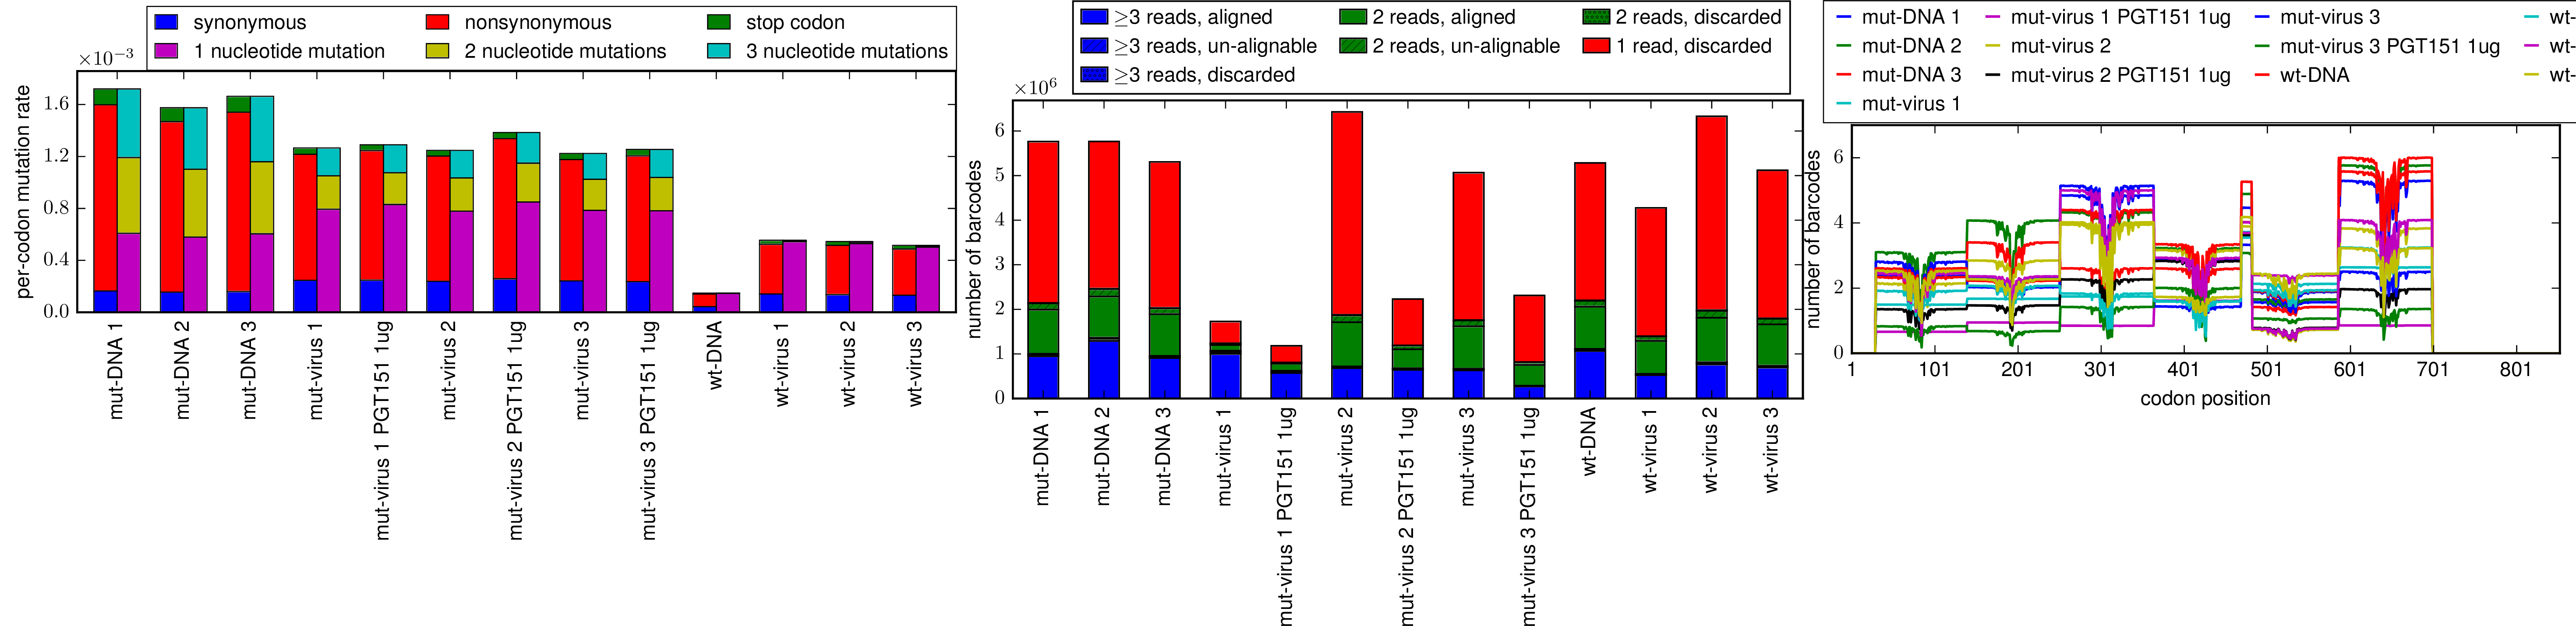

In [5]:
summaryprefix = '{0}/summary_'.format(countsdir)
summaryplots = [summaryprefix + suffix for suffix in ['mutfreqs.pdf', 'barcodes.pdf', 'depth.pdf']]
if not all(map(os.path.isfile, summaryplots)):
    print("Creating summary plots...")
    subprocess.check_call(['dms_summarizealignments', summaryprefix, 'barcodedsubamplicons'] + 
            ['{0},{1}'.format(x, os.path.basename(x).replace('_', ' ')) for x in sorted(outprefixes)] + 
            ['--writemutfreqs'])
print("Here are the summaryplots:")
ShowPDF(summaryplots)

The plot at left shows that the sequencing error-rate is low on the control sequencing of unmutated DNA (*wt-DNA* sample). The error rate is somewhat elevated when sequencing wildtype virus created from this plasmid (*wt-virus*), although still well below the mutation rate in the mutagenized libraries. There is evidence of purging of deleterious mutations from the mutant plasmid libraries (*mut-DNA*) relative to the mutant viruses (*mut-virus*) grown from these plasmids, both in the presence and absence of PGT151 antibody.

## Renumber residues using HXB2 numbering scheme, trim down to the mutagenized residues
The standard HIV numbering scheme is based on HXB2. The conversion between sequential numbering of BF520 and HXB2 is in the file `BF520c2_to_HXB2.txt`. This file was generated by aligning the HXB2 sequence [taken from Genbank](http://www.ncbi.nlm.nih.gov/protein/1906385) with the BF520c2 sequence using the [LANL alignment interface](http://www.hiv.lanl.gov/cgi-bin/VIRALIGN/viralign.cgi) at the protein sequence level. Insertions relative to HXB2 are given letter suffixes as [described here](http://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).

Additionally, not all residues in BF520 Env were mutagenized. The N-terminal signal peptide and the C-terminal cytoplasmic tail were excluded because they seem likely to affect expression level. The file `remove_unmutated_codons.txt` gives the sites that were *not* mutagenized (and so should be excluded; sites 1-30 and 692-853) in the BF520 sequential numbering scheme. 

In [7]:
removesites = 'remove_unmutated_codons.txt'
renumbersites = 'BF520c2_to_HXB2.txt'

countsfiles = []
for prefix in sorted(outprefixes):
    countsfile = prefix + 'counts.txt'
    trimmedcountsfile = '{0}/trim_{1}'.format(os.path.dirname(countsfile), os.path.basename(countsfile))
    renumberedcountsfile = '{0}/renumbered_{1}'.format(os.path.dirname(countsfile), os.path.basename(countsfile))
    countsfiles.append(renumberedcountsfile)
    if os.path.isfile(renumberedcountsfile):
        print("Renumbered and trimmed file {0} already exists.".format(renumberedcountsfile))
    else:
        print("Creating trimmed file {0}".format(trimmedcountsfile))
        tempfile = '_tempcounts.txt'
        subprocess.check_call(['dms_editsites', countsfile, trimmedcountsfile, 'remove', removesites])
        print("Creating renumbered and trimmed file {0}".format(renumberedcountsfile))
        subprocess.check_call(['dms_editsites', trimmedcountsfile, renumberedcountsfile, 'renumber', renumbersites])
countsfiles.sort()
print("Renumbered counts files exists for all samples.")

Renumbered and trimmed file ./counts/renumbered_mut-DNA_1_counts.txt already exists.
Renumbered and trimmed file ./counts/renumbered_mut-DNA_2_counts.txt already exists.
Renumbered and trimmed file ./counts/renumbered_mut-DNA_3_counts.txt already exists.
Renumbered and trimmed file ./counts/renumbered_mut-virus_1_counts.txt already exists.
Renumbered and trimmed file ./counts/renumbered_mut-virus_1_PGT151_1ug_counts.txt already exists.
Renumbered and trimmed file ./counts/renumbered_mut-virus_2_counts.txt already exists.
Renumbered and trimmed file ./counts/renumbered_mut-virus_2_PGT151_1ug_counts.txt already exists.
Renumbered and trimmed file ./counts/renumbered_mut-virus_3_counts.txt already exists.
Renumbered and trimmed file ./counts/renumbered_mut-virus_3_PGT151_1ug_counts.txt already exists.
Renumbered and trimmed file ./counts/renumbered_wt-DNA_counts.txt already exists.
Renumbered and trimmed file ./counts/renumbered_wt-virus_1_counts.txt already exists.
Renumbered and trimmed

## Assess how well mutations were sampled in the mutant DNA libraries
We want to determine the number of times each mutation was sampled in each *mutDNA* library prior to any selection. This provides some indication of how comprehensive the mutant libraries were.


In [8]:
dfs = {}
for f in countsfiles:
    if 'mut-DNA' in f:
        replicate = int(f.split('_')[-2])
        df = dms_tools.file_io.ReadDMSCounts(f, 'codon', translate_codon_to_aa=True, 
                return_as_df=True).transpose()
        dfs['replicate {0}'.format(replicate)] = df
        if 'combined replicates' in dfs:
            dfs['combined replicates'] = dfs['combined replicates'].add(df, fill_value=0)
        else:
            dfs['combined replicates'] = df

for (replicate, df) in sorted(dfs.items()):
    print("For {0}:".format(replicate))
    for cutoff in [1, 2, 5, 10]:
        nmutspossible = len(df) * (len(dms_tools.aminoacids) - 1)
        nmutsfound = -len(df) # we need to subtract the counts for wildtype amino acids
        for aa in dms_tools.aminoacids:
            nmutsfound += len(df[(df[aa] > cutoff)])
        print("\t{1} of {2} mutations ({3:.2f}%) are found at least {4} times.".format(
                    replicate, nmutsfound, nmutspossible, 100.0 * nmutsfound / nmutspossible, cutoff))

For combined replicates:
	12427 of 12559 mutations (98.95%) are found at least 1 times.
	12343 of 12559 mutations (98.28%) are found at least 2 times.
	12037 of 12559 mutations (95.84%) are found at least 5 times.
	11365 of 12559 mutations (90.49%) are found at least 10 times.
For replicate 1:
	11921 of 12559 mutations (94.92%) are found at least 1 times.
	11476 of 12559 mutations (91.38%) are found at least 2 times.
	10072 of 12559 mutations (80.20%) are found at least 5 times.
	7892 of 12559 mutations (62.84%) are found at least 10 times.
For replicate 2:
	11865 of 12559 mutations (94.47%) are found at least 1 times.
	11512 of 12559 mutations (91.66%) are found at least 2 times.
	10270 of 12559 mutations (81.77%) are found at least 5 times.
	8156 of 12559 mutations (64.94%) are found at least 10 times.
For replicate 3:
	11880 of 12559 mutations (94.59%) are found at least 1 times.
	11377 of 12559 mutations (90.59%) are found at least 2 times.
	9762 of 12559 mutations (77.73%) are fou

## Compute the differential selection and correlations between replicates
Now we compute the differential selection for each replicate, using the *wt-virus* controls to estimate the error rates.

We also compute the average differential selection for each antibody.

Finally, we look at correlations between pairs of replicates in mutation and site differential selection, restricting to only positive differential selection.

Differential selection for replicate 1 with PGT151_1ug already exists.
Differential selection for replicate 2 with PGT151_1ug already exists.
Differential selection for replicate 3 with PGT151_1ug already exists.

Here are the sitediffsel correlations between replicates for PGT151_1ug:


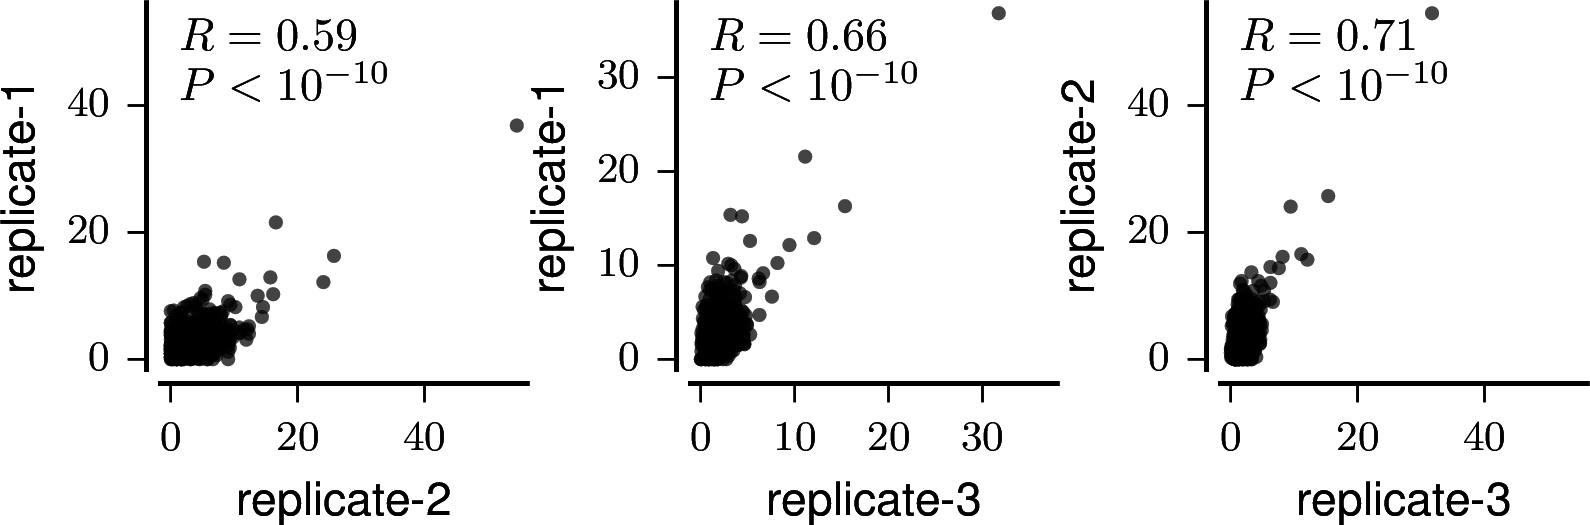


Here are the mutdiffsel correlations between replicates for PGT151_1ug:


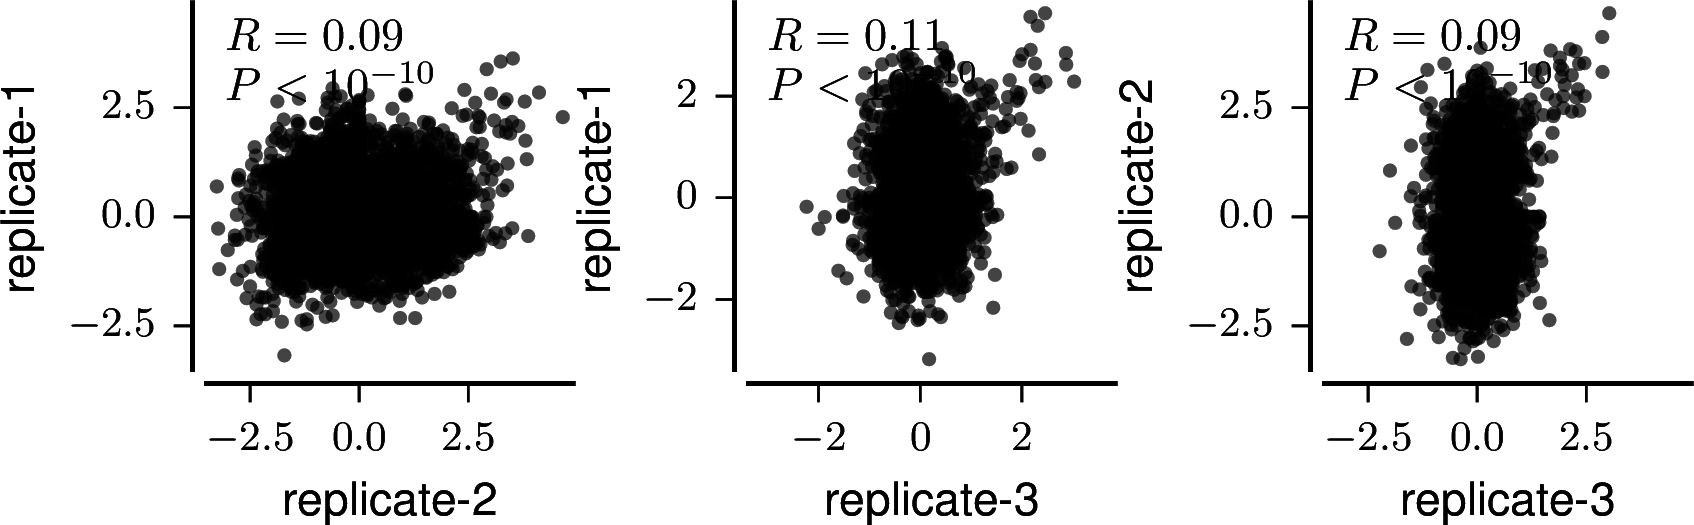

Average differential selection for PGT151_1ug already exists.
Computed differential selection for all experiments.


In [12]:
diffseldir = './diffsel'
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)

diffsels = {}
for antibody in antibodies:
    # compute diffsel
    diffsels[antibody] = []
    corrplots = {}
    for replicate in replicates:
        mock = '{0}/renumbered_mut-virus_{1}_counts.txt'.format(countsdir, replicate)
        errorcontrol = '{0}/renumbered_wt-virus_{1}_counts.txt'.format(countsdir, replicate)
        selected = '{0}/renumbered_mut-virus_{1}_{2}_counts.txt'.format(countsdir, replicate, antibody)
        outprefix = '{0}/{1}_{2}_'.format(diffseldir, antibody, replicate)
        mutdiffsel = outprefix + 'mutdiffsel.txt'
        if os.path.isfile(mutdiffsel):
            print("Differential selection for replicate {0} with {1} already exists.".format(replicate, antibody))
        else:
            print("Computing differential selection for replicate {0} with {1}...".format(replicate, antibody))
            subprocess.check_call(['dms_diffselection', mock, selected, outprefix, 
                    '--errorcontrolcounts', errorcontrol])
            
        # plot correlations
        for seltype in ['mutdiffsel', 'sitediffsel']:
            if seltype not in corrplots:
                corrplots[seltype] = []
            for (replicate2, mutdiffsel2) in zip(replicates, diffsels[antibody]):
                f1 = mutdiffsel.replace('mutdiffsel', seltype)
                f2 = mutdiffsel2.replace('mutdiffsel', seltype)
                plotprefix = '{0}/{1}_{2}_vs_{3}_{4}'.format(diffseldir, antibody, replicate2, replicate, seltype)
                plot = plotprefix + '.pdf'
                if not os.path.isfile(plot):
                    subprocess.check_call(['dms_correlate', f1, f2, plotprefix, '--corr_on_plot',
                            '--name1', 'replicate-{0}'.format(replicate), 
                            '--name2', 'replicate-{0}'.format(replicate2),
                            '--restrictdiffsel', 'positive',
                            '--alpha', '0.45',
                            '--markersize', '6'])
                corrplots[seltype].append(plot)
            
        diffsels[antibody].append(mutdiffsel)
        
    # plot correlations
    for (seltype, plots) in corrplots.items():
        print("\nHere are the {0} correlations between replicates for {1}:".format(seltype, antibody))
        ShowPDF(corrplots[seltype])
        
    # get average for antibody  
    avgmutdiffsel = '{0}/{1}_average_mutdiffsel.txt'.format(diffseldir, antibody)
    if os.path.isfile(avgmutdiffsel):
        print("Average differential selection for {0} already exists.".format(antibody))
    else:
        print("Computing average differential selection with {0}...".format(antibody))
        subprocess.check_call(['dms_merge', avgmutdiffsel, 'average'] + diffsels[antibody] + 
                ['--sitediffsel', avgmutdiffsel.replace('mutdiffsel', 'sitediffsel')])
    diffsels[antibody].append(avgmutdiffsel) 
    
print("Computed differential selection for all experiments.")

In [10]:
#now, generating sitediffsel.txt files using the original BF520 numbering, to be input for the diffselbysite line plot
diffseldir = './diffsel/BF520numbering/'
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)

diffselsBF520 = {}
for antibody in antibodies:
    # compute diffsel
    diffselsBF520[antibody] = []
    corrplots = {}
    for replicate in replicates:
        mock = '{0}/trim_mut-virus_{1}_counts.txt'.format(countsdir, replicate)
        errorcontrol = '{0}/trim_wt-virus_{1}_counts.txt'.format(countsdir, replicate)
        selected = '{0}/trim_mut-virus_{1}_{2}_counts.txt'.format(countsdir, replicate, antibody)
        outprefix = '{0}/{1}_{2}_'.format(diffseldir, antibody, replicate)
        mutdiffselBF520 = outprefix + 'mutdiffsel.txt'
        if os.path.isfile(mutdiffselBF520):
            print("Differential selection for replicate {0} with {1} with BF520 numbering already exists.".format(replicate, antibody))
        else:
            print("Computing differential selection again for replicate {0} with {1} (using BF520 numbering)...".format(replicate, antibody))
            subprocess.check_call(['dms_diffselection', mock, selected, outprefix, 
                    '--errorcontrolcounts', errorcontrol])
        diffselsBF520[antibody].append(mutdiffselBF520)

    avgmutdiffselBF520 = '{0}/{1}_average_mutdiffsel.txt'.format(diffseldir, antibody)
    if os.path.isfile(avgmutdiffselBF520):
        print("Average differential selection for {0} already exists.".format(antibody))
    else:
        print("Computing average differential selection with {0}...".format(antibody))
        subprocess.check_call(['dms_merge', avgmutdiffselBF520, 'average'] + diffselsBF520[antibody] + 
                ['--sitediffsel', avgmutdiffselBF520.replace('mutdiffsel', 'sitediffsel')])
    diffselsBF520[antibody].append(avgmutdiffselBF520)
print("Computed differential selection  using BF520 numbering for all experiments.")

Differential selection for replicate 1 with PGT151_1ug with BF520 numbering already exists.
Differential selection for replicate 2 with PGT151_1ug with BF520 numbering already exists.
Differential selection for replicate 3 with PGT151_1ug with BF520 numbering already exists.
Average differential selection for PGT151_1ug already exists.
Computed differential selection  using BF520 numbering for all experiments.


## Make logo plots with informative overlays
Note that all the `mutdiffsel` values are in *diffsels[antibody]*, so you can just loop over those to make the logo plots.

['./diffsel/PGT151_1ug_1_mutdiffsel.txt', './diffsel/PGT151_1ug_2_mutdiffsel.txt', './diffsel/PGT151_1ug_3_mutdiffsel.txt', './diffsel/PGT151_1ug_average_mutdiffsel.txt']
./diffsel/PGT151_1ug_1_mutdiffsel.txt ./diffsel/PGT151_1ug_2_mutdiffsel.txt ./diffsel/PGT151_1ug_3_mutdiffsel.txt ./diffsel/PGT151_1ug_average_mutdiffsel.txt
Differential selection plot for ./diffsel/PGT151_1ug_1_mutdiffsel.txt already exists.
Differential selection plot for ./diffsel/PGT151_1ug_2_mutdiffsel.txt already exists.
Differential selection plot for ./diffsel/PGT151_1ug_3_mutdiffsel.txt already exists.
Differential selection plot for ./diffsel/PGT151_1ug_average_mutdiffsel.txt already exists.
Differential selection plot for ./diffsel/PGT151_1ug_average_mutdiffsel_annotated_logoplot.pdf already exists.
Here is the diffsel for ./diffsel/PGT151_1ug_average_mutdiffsel_annotated_logoplot.pdf: 



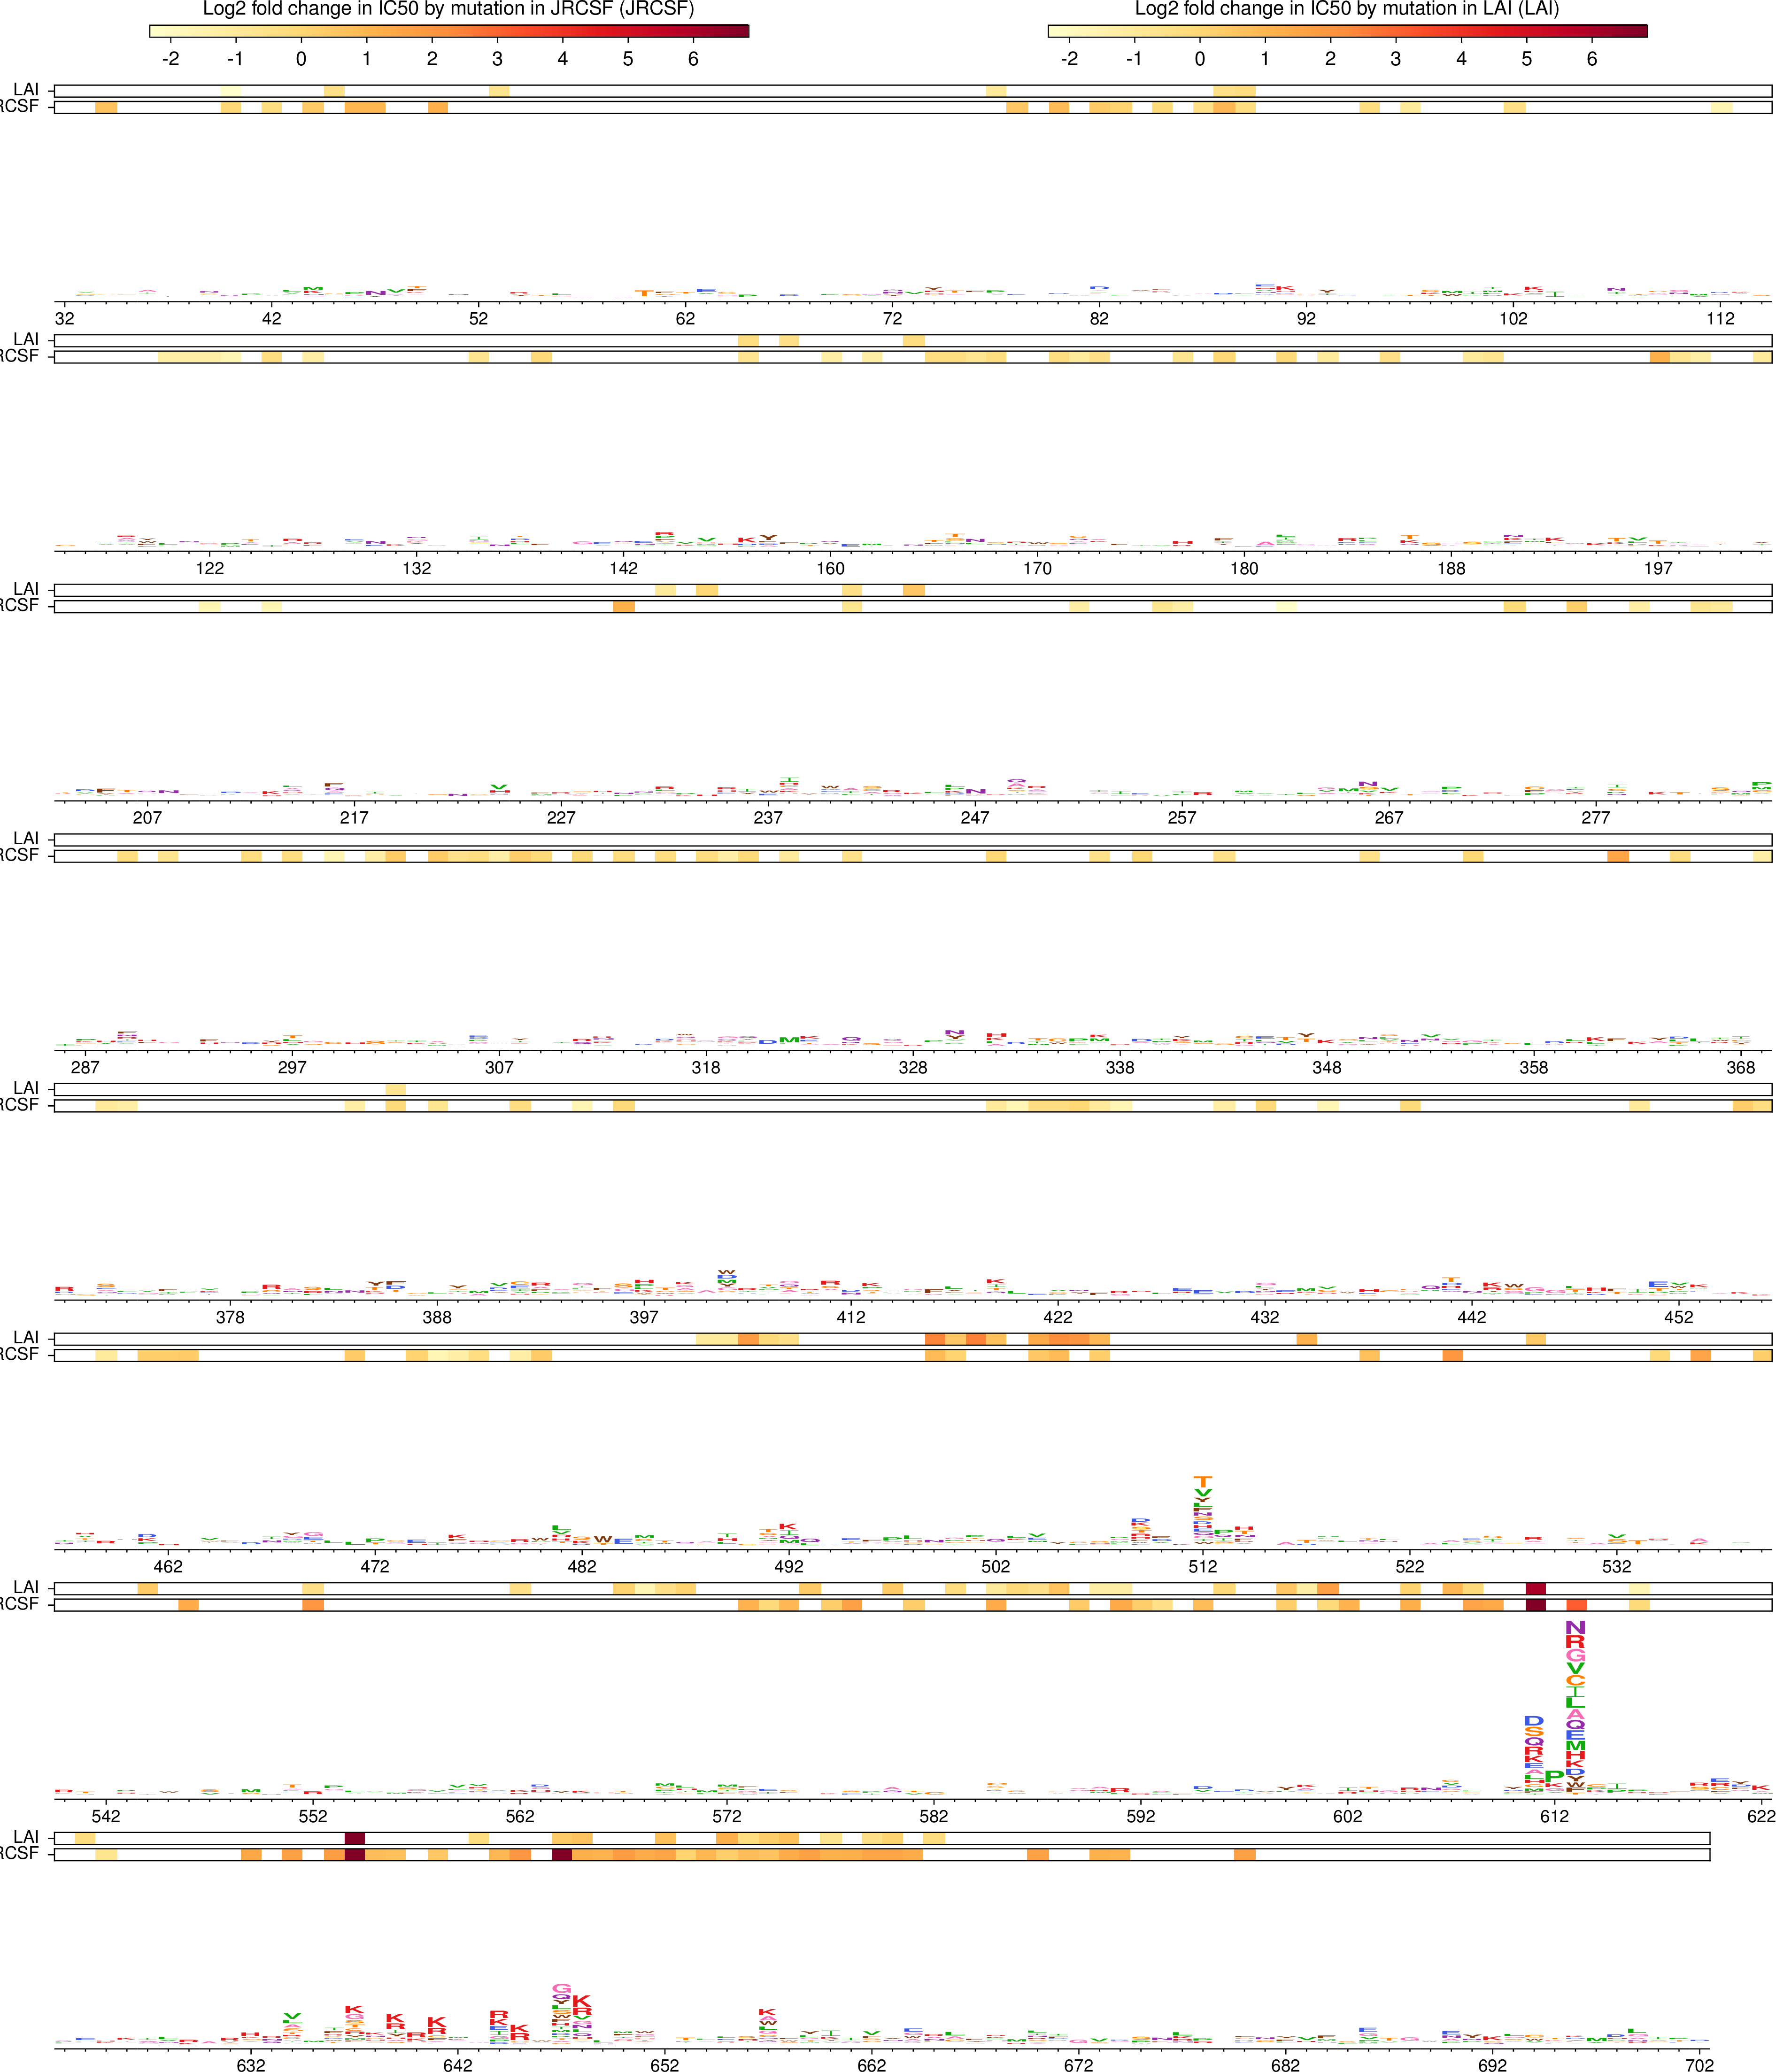

In [13]:
diffseldir = './diffsel/'
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)
overlay_cmap = 'YlOrRd'

nperline = '83'
for antibody in antibodies:
    print diffsels[antibody]
    diffselstring = ' '.join(diffsels[antibody])
    print diffselstring
    for mutdifsel in diffsels[antibody]:
        logoplotname = mutdifsel.replace('.txt','_logoplot.pdf')
        if os.path.isfile(logoplotname):
            print("Differential selection plot for {0} already exists.".format(mutdifsel))
        else:
            print("Plotting differential selection for {0}...".format(mutdifsel))
            subprocess.check_call(['dms_logoplot', mutdifsel, logoplotname, '--nperline', nperline, '--restrictdiffsel', 'positive', '--mapmetric', 'functionalgroup', '--colormap', 'mapmetric', '--nosepline', '--diffselheight'] + diffsels[antibody])
            #could plot these all on the same axis?
#plotting averaged defsel, pos only, with overlays
filename1="JRCSFalaninescandata_logbase2_115foldlimit.txt" 
shortname1= "JRCSF"
longname1= "Log2 fold change in IC50 by mutation in JRCSF"

filename2="LAIalaninescandata_logbase2.txt"
shortname2= "LAI"
longname2= "Log2 fold change in IC50 by mutation in LAI"

annotatedlogoplotname = avgmutdiffsel.replace('.txt','_annotated_logoplot.pdf')
if os.path.isfile(annotatedlogoplotname):
    print("Differential selection plot for {0} already exists.".format(annotatedlogoplotname))
else:
    print("Plotting differential selection for {0}...".format(annotatedlogoplotname))
    subprocess.check_call(['dms_logoplot', avgmutdiffsel, annotatedlogoplotname, '--nperline', nperline, 
            '--restrictdiffsel', 'positive',
            '--nosepline',
            '--mapmetric', 'functionalgroup',
            '--colormap', 'mapmetric',
            '--overlay_cmap', overlay_cmap,
            '--overlay1', filename1, shortname1, longname1,
            '--overlay2', filename2, shortname2, longname2])
print "Here is the diffsel for %s: \n" % annotatedlogoplotname
pdf = annotatedlogoplotname
ShowPDF(pdf, width=600)

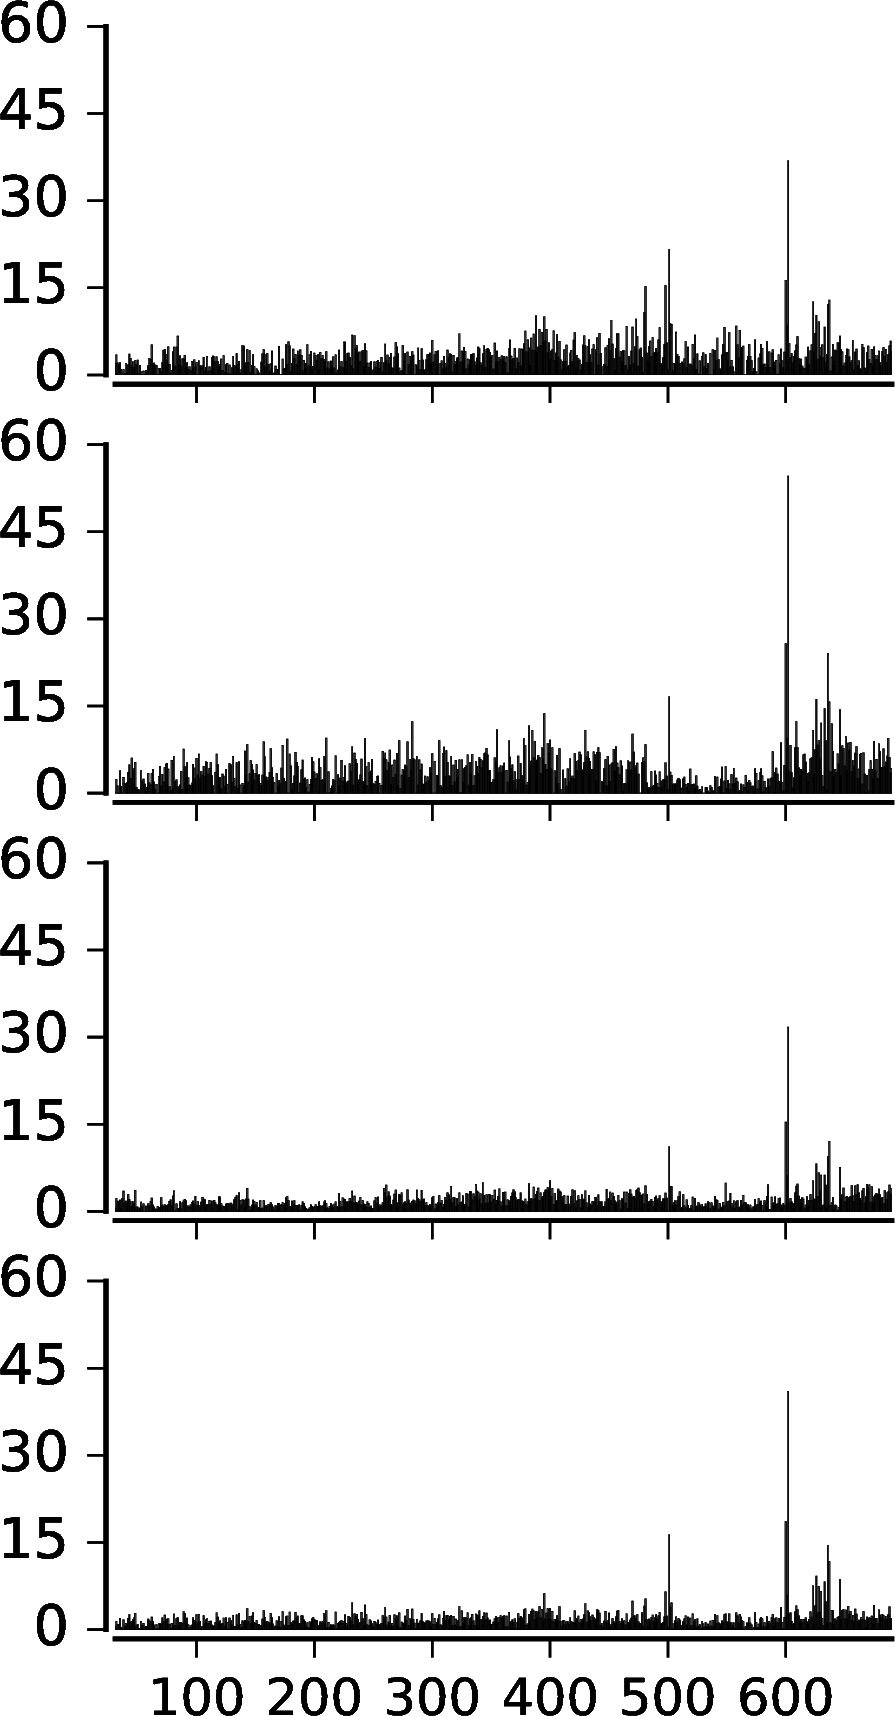

In [17]:
#make histogram of length of gene. These plots use BF520 numbering. The function was written by Mike Doud. 

def PlotPosDiffselBySiteSubplots(sitediffsel_files, sites, numcols, numrows, 
                                outfile=False, ylims=False, xlims=False,
                                figsize_horizontal = 12, figsize_vertical = 8,
                                bar_width = 1, custom_xticks=None):
    '''
    Plot positive differential selection for a given set of sites for several samples arranged in subplots.
    provide *sitediffsel.txt to be plotted left-to-right, top-to-bottom.
    numcols * numrows = len(codon_counts_files)
    '''
    
    # check inputs
    assert len(sitediffsel_files) == numcols*numrows
    
    fig, axes = plt.subplots(nrows=numrows, ncols=numcols, 
                             sharex='col', sharey='row', figsize=(figsize_horizontal,figsize_vertical))
    
    for i,ax in enumerate(axes.flatten()):
                
        # get the data:
        diffsel = pd.read_csv(sitediffsel_files[i])

        # extract the positive diffsel values for each site in the list of *sites*:
        pos_diffsels = [ float(diffsel.loc[diffsel['site'] == r]['positive_diffsel'])  for r in sites]

        ax.bar(sites, pos_diffsels, bar_width, color = 'k', alpha = 1, linewidth=0.1, align='center')

        if ylims:
            ax.set_ylim(bottom=ylims[0], top=ylims[1])
        else:
            pass
        if xlims:
            ax.set_xlim(bottom=xlims[0], top=xlims[1])
        else:
            ax.set_xlim(left=min(sites), right=max(sites))
    
    # clean up axes
    spineOffset = {'left': 2, 'bottom': 2}
    for ax in axes.reshape(-1):
        [spine.set_position(('outward',spineOffset[loc])) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in ax.spines.items() ] 
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', direction='out')
        ax.xaxis.set(ticks_position = 'bottom',  major_locator = MaxNLocator(len(sites), prune=None))
        ax.yaxis.set(ticks_position = 'left', major_locator = MaxNLocator(4, prune=None))
        
    # remove tick labels for all:
    for ax in axes.reshape(-1):
        for xlabel_i in ax.get_xticklabels():
            xlabel_i.set_visible(False)
        for ylabel_i in ax.get_yticklabels():
            ylabel_i.set_visible(False)
    
    # add tick labels to left and bottom:
    if numcols == 1:
        for i, xlabel_i in enumerate(axes[-1].get_xticklabels()):
            xlabel_i.set_visible(True)
            plt.setp(xlabel_i, rotation=0, fontsize=11)
    else:
        for ax in axes[-1]:
            for i, xlabel_i in enumerate(ax.get_xticklabels()):
                xlabel_i.set_visible(True)
                plt.setp(xlabel_i, rotation=0, fontsize=11)

    if numcols == 1:
        for ax in axes:
            for ylabel_i in ax.get_yticklabels():
                ylabel_i.set_visible(True)
    else:
        for ax in axes[:,0]:
            for ylabel_i in ax.get_yticklabels():
                ylabel_i.set_visible(True)
                
    # override with custom xticks and labels if provided
    if custom_xticks is not None:
        plt.xticks(custom_xticks, custom_xticks)

    filepath = 'diffsel/test_diffselbarplots.pdf'
    if outfile:
        filepath = outfile
    plt.savefig(filepath)
    plt.close()
    
    #below unedited
outfile = 'diffsel/PosDiffselbysite_PGT151_1ug_replicates.pdf'
numcols = 1
numrows = 3

# left-to-right, top-to-bottom order for subplots
sitediffsel_files = ['diffsel/BF520numbering/PGT151_1ug_1_sitediffsel.txt',
                     'diffsel/BF520numbering/PGT151_1ug_2_sitediffsel.txt',
                     'diffsel/BF520numbering/PGT151_1ug_3_sitediffsel.txt',]

sites = range(31, 691) #
custom_xticks = [100,200,300,400,500,600]

PlotPosDiffselBySiteSubplots(sitediffsel_files, sites, numcols, numrows, outfile=outfile, 
                            ylims=(0,60), figsize_horizontal = 4, figsize_vertical = 6,
                           bar_width=1, custom_xticks=custom_xticks)

#ShowPDF(outfile, width=300)

outfile = 'diffsel/PosDiffselbysite_PGT151_1ug_avg.pdf'
numcols = 1
numrows = 4

# left-to-right, top-to-bottom order for subplots
sitediffsel_files = ['diffsel/BF520numbering/PGT151_1ug_1_sitediffsel.txt',
                     'diffsel/BF520numbering/PGT151_1ug_2_sitediffsel.txt',
                     'diffsel/BF520numbering/PGT151_1ug_3_sitediffsel.txt',
                     'diffsel/BF520numbering/PGT151_1ug_average_sitediffsel.txt',]

sites = range(31, 691) #
custom_xticks = [100,200,300,400,500,600]

PlotPosDiffselBySiteSubplots(sitediffsel_files, sites, numcols, numrows, outfile=outfile, 
                            ylims=(0,60), figsize_horizontal = 3, figsize_vertical = 6,
                            bar_width=1, custom_xticks=custom_xticks)

ShowPDF(outfile, width=280)